In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Training Core

> The `text.training.core` module contains the core bits required to train text/NLP models with fast.ai

In [ ]:
# |default_exp text.training.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import (
    AutoConfig,
    AutoTokenizer,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
    AutoModelForSequenceClassification,
)
from transformers import logging as hf_logging

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.transforms import DataLoader, DataLoaders, Datasets
from fastai.optimizer import Adam, OptimWrapper, params
from datasets import concatenate_datasets, load_dataset, Value
from fastai.data.block import MultiCategoryBlock, CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import (
    print_versions,
    set_seed,
    PreCalculatedLoss,
    PreCalculatedCrossEntropyLoss,
    PreCalculatedBCELoss,
    PreCalculatedMSELoss,
)
from blurr.text.data.core import *

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"Much worse than the original. It was actually *painful* to sit through, and it barely held my six year old's interest.<br /><br />Introduction of some new Pokemon is marginally interesting, but storyline is extra-thin, dialogue is still bad, and music is mediocre. Watch the television show instead - it's much better.",0,False
1,This movie is just plain terrible. Poor John Savage had to stoop this low in order to be in another movie. He stars as a rare type of vampire that is to help a lady that looks like a washed out and thrown in the streets hooker that is a dancer at a local strip club. She acidently tastes a drop of blood from another dancer who happens to be one of those rare vampires as they get carried away making out on the floor of the dressing room. Savage is then assigned by a short leader of this rare vampire breed that looks like a cross between 80's punk rock and one of the Olsen twins with purple h...,0,False
2,"The characters are cliched and predictable, with everyone being either snow-white pure or wholly evil. The acting is too stilted for it to be bad in an amusing, over-the-top way. It's doubly disappointing if you're a Bette Davis fan, because her character is not a typically fun Bette-Davis-type character; she just gets to frown pensively a lot.<br /><br />On the whole, neither my wife nor I found the movie to be interesting, moving or enjoyable at all.",0,False
3,"Normally, I am a pretty generous critic, but in the case of this film I have to say it was incredibly bad. I am stunned by how positive most reviews seem to be.<br /><br />There were some gorgeous shots, but it's too bad they were wasted on this sinkhole of a movie. It might have worked if ""Daggers"" was purely an action flick and not a romance, but unfortunately the film is built around an empty love triangle. There is no chemistry between either of the couples, whatever exists between Mei and her men seems to be more lust than love, and for the most part the dialogue is just silly. This m...",0,False
4,"This is one of the best films I have seen in years! I am not a Gwyneth Paltrow fan, but she is excellent as Emma Woodhouse. Alan Cumming is superb as Reverand Elton, and Emma Thompson's sister, Sophie, is hysterical as Miss Bates. And check out the gorgeous Jeremy Northam as Mr. Knightley; what a gentleman! Whoever said you need sex and violence in a movie to make it good has never seen Emma. I think that is what separates it from so many others--it's classy.<br /><br />If you're looking for a film that you can watch with the whole family, or looking for a romance for yourself, look no fur...",1,False


In [ ]:
label_names = imdb_dsd[0].features["label"].names
label_names

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_label_names = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_label_names:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_label_names:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,Thank you Senator French; short and to the point! We all need to ask them to vote no and go back to the drawing board.,0,0,0,0,0,0,0,False
1,"The weather doesn't seem that unusual to me. I always remember back in the day, (the 70s and 80s) that Memorial Day Weekend would be when it was finally hot enough to sunbathe. I also don't remember that every time we'd have a few days of nice weather that there would be all this doom and gloom about wildfires. Of course, there was no Internet and news articles like this weren't in our face all the time.",0,0,0,0,0,0,0,False
2,"""... Trudeau asserted it is not up to the federal government to challenge its constitutionality."" Perhaps he is correct, but what will he say if the Supreme Court slams it down and the Quebec government invokes the notwithstanding clause? That would test his sunny ways and resolve.",0,0,0,0,0,0,0,False
3,"""Quebec, Canada and the national unity crisis we outgrew""\n\n\nOutgrew?? More like ""that can was kicked down the street"". After 40 years Quebec still hasn't signed the Constitution. What happened to Trudeau? I thought he said ""unlike the last ten years"" we're all now ""going to have a national conversation"" on this. Where's Trudeau? Of course, like electoral reform , after winning an election reality kicks in. Timid Trudeau said abruptly that he's refusing to open up the negotiations. Trudeau just doesn't have the temperament to deal with tedious Canadian issues. He'd rather travel around ...",0,0,0,0,0,0,0,False
4,Neil try asking President Elect Trump and see where that gets you. It will be nice to see people who think because they sing songs or act that somehow they should be listened to.,0,0,0,0,0,0,0,False


## Base API

Base plitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L41){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L48){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
# |export
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L60){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Base API: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["Much worse than the original. It was actually *painful* to sit through, and it barely held my six year old's interest.<br /><br />Introduction of some new Pokemon is marginally interesting, but storyline is extra-thin, dialogue is still bad, and music is mediocre. Watch the television show instead - it's much better.", "This movie is just plain terrible. Poor John Savage had to stoop this low in order to be in another movie. He stars as a rare type of vampire that is to help a lady that looks like a washed out and thrown in the streets hooker that is a dancer at a local strip club. She acidently tastes a drop of blood from another dancer who happens to be one of those rare vampires as they get carried away making out on the floor of the dressing room. Savage is then assigned by a short leader of this rare vampire breed that looks like a cross between 80's punk rock and one of the Olsen twins with purple hair. This movie just gets all to c

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
b

250 25


({'input_ids': tensor([[     1,   7924,    262,   1650,    269,   2902,    264,    282,    347,
              747,    265,  26849,    270,    262,   1553,    280,    268,   5471,
              287,    724,  61638,    268,    300,  29570,    278,    270,    381,
              285,    260,   2144,  11110,    261,    337,    291,   1421,   1150,
              280,    297,   4727,    271,   5203,    271,   6578,    261,    278,
              403,    286,    331,    261,    278,    280,    268,    324,  14118,
              759,    271,  28026,    261,    494, 103188,    261,    494,  54495,
              261,    263,   4069,    469,   2284,    280,    268,  38406,   2488,
            19316,    260,  10418,    269,  51152,    261,    263,    274,    387,
            27527,    339,   2005,    264,   1012,    267,    291,    311,    260,
            94679,    701,   2308,   1950,   2488,    270,    262,    966,    261,
              966,   4957,    260,      2,      0,      0,      0,      0,

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=1.0964782268274575e-05, steep=0.0030199517495930195, valley=2.511886486900039e-05, slide=0.00015848931798245758)

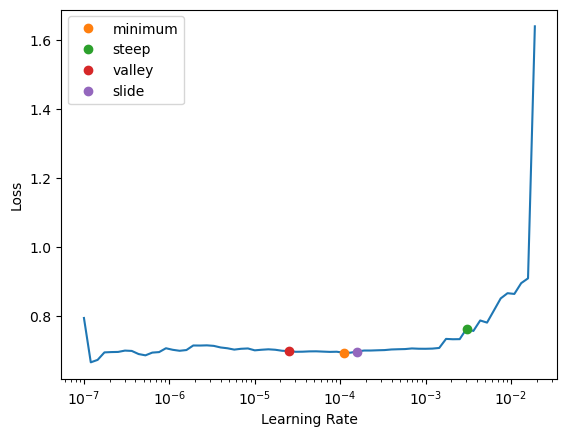

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.17362810671329498
valid_loss 0.21244704723358154
accuracy 0.9200000166893005


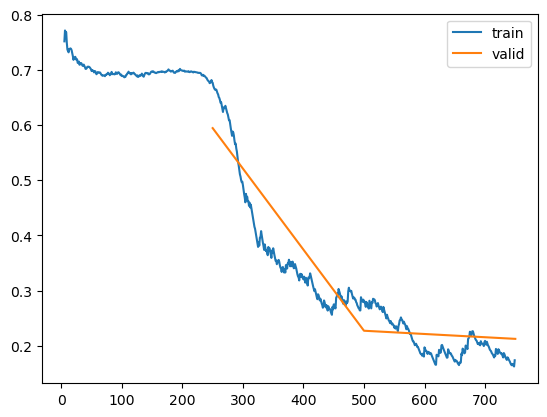

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['Thank you Senator French; short and to the point! We all need to ask them to vote no and go back to the drawing board.', "The weather doesn't seem that unusual to me. I always remember back in the day, (the 70s and 80s) that Memorial Day Weekend would be when it was finally hot enough to sunbathe. I also don't remember that every time we'd have a few days of nice weather that there would be all this doom and gloom about wildfires.  Of course, there was no Internet and news articles like this weren't in our face all the time."], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['Thank you Senator French; short and to the point! We all need to ask them to vote no and go back to the drawing board.', "The weather doesn't seem that unusual to me. I always remember back in the day, (the 70s and 80s) that Memori

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
# proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_label_names)

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)
# proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_label_names)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_label_names)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_label_names)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.002290867641568184, steep=0.05754399299621582, valley=0.0002290867705596611, slide=0.0004786300996784121)

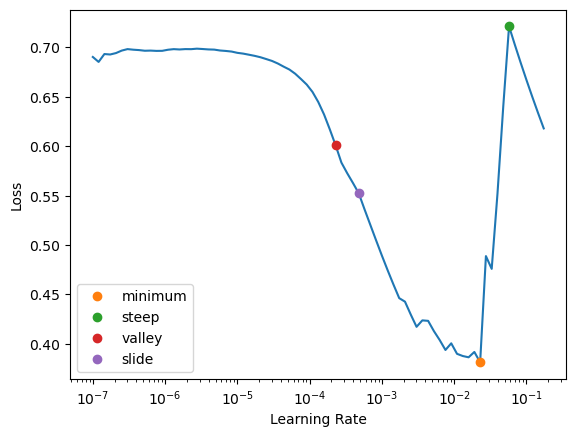

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06846776604652405
valid_loss 0.08837293833494186
accuracy_multi 0.9778571128845215


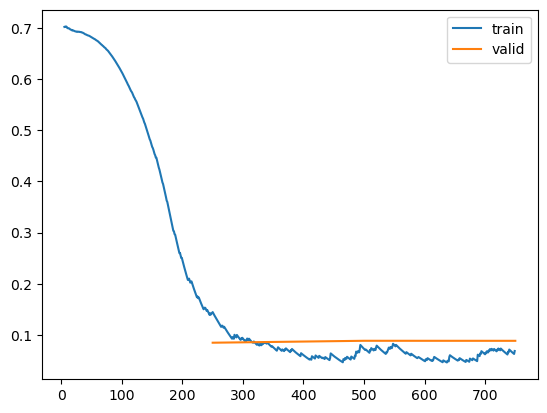

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["Much worse than the original. It was actually *painful* to sit through, and it barely held my six year old's interest.<br /><br />Introduction of some new Pokemon is marginally interesting, but storyline is extra-thin, dialogue is still bad, and music is mediocre. Watch the television show instead - it's much better.", "This movie is just plain terrible. Poor John Savage had to stoop this low in order to be in another movie. He stars as a rare type of vampire that is to help a lady that looks like a washed out and thrown in the streets hooker that is a dancer at a local strip club. She acidently tastes a drop of blood from another dancer who happens to be one of those rare vampires as they get carried away making out on the floor of the dressing room. Savage is then assigned by a short leader of this rare vampire breed that looks like a cross between 80's punk rock and one of the Olsen twins with purple hair. This movie just gets all to c

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-36b664068cd5f7a0.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=9.12010818865383e-08, steep=7.585775847473997e-07, valley=4.365158383734524e-05, slide=0.00010964782268274575)

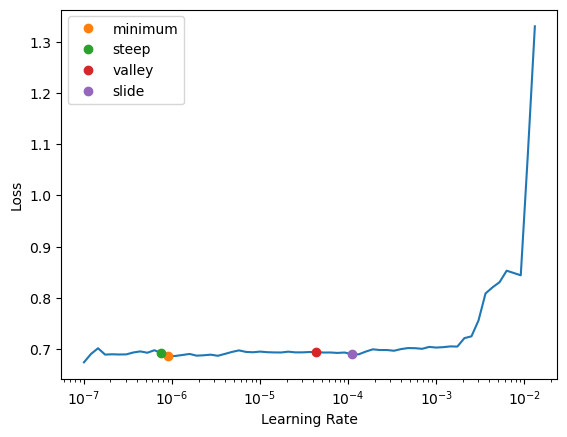

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.17001855373382568
valid_loss 0.205769345164299
accuracy 0.9100000262260437


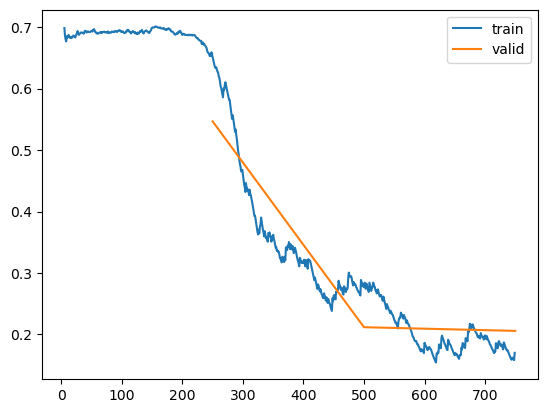

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['Thank you Senator French; short and to the point! We all need to ask them to vote no and go back to the drawing board.', "The weather doesn't seem that unusual to me. I always remember back in the day, (the 70s and 80s) that Memorial Day Weekend would be when it was finally hot enough to sunbathe. I also don't remember that every time we'd have a few days of nice weather that there would be all this doom and gloom about wildfires.  Of course, there was no Internet and news articles like this weren't in our face all the time."], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['Thank you Senator French; short and to the point! We all need to ask them to vote no and go back to the drawing board.', "The weather doesn't seem that unusual to me. I always remember back in the day, (the 70s and 80s) that Memori

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_label_names], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
# proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True, batch_size=4)
# proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_civil_train_ds)
print(proc_civil_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.002290867641568184, steep=0.0002290867705596611, valley=0.0002754228771664202, slide=0.007585775572806597)

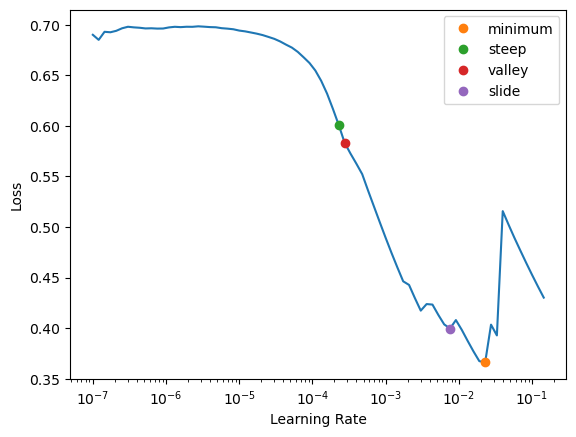

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06846854835748672
valid_loss 0.08837345987558365
accuracy_multi 0.9778571128845215


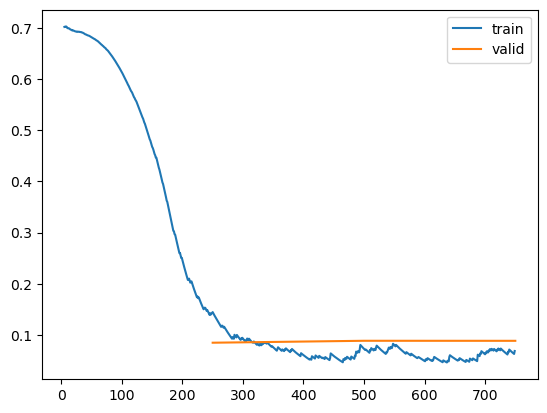

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_label_names = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
    if trg_label_names is None and learner.dls.vocab is not None:
        trg_label_names = learner.dls.vocab

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        pred = outs[idx]

        # add in the input text
        input_ids = x[idx]
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]

        # add in the targets
        sample = samples[idx] if samples is not None else None
        for item_idx, item in enumerate(sample[n_inp:]):
            label = y[item_idx] if y is not None else item

            if torch.is_tensor(label):
                label = list(label.numpy()) if len(label.size()) > 0 else label.item()

            if is_listy(label):
                trg = [trg_label_names[int(idx)] for idx, val in enumerate(label) if (val == 1)] if trg_label_names else label
            else:
                trg = trg_label_names[int(item)] if trg_label_names else item

            rets.append(trg)

        # add in the predictions
        for item in pred:
            if torch.is_tensor(item):
                item = list(item.numpy()) if len(item.size()) > 0 else item.item()

            if is_listy(item):
                p = [trg_label_names[int(idx)] for idx, val in enumerate(item) if (val == 1)] if trg_label_names else item
            else:
                p = trg_label_names[int(item)] if trg_label_names else item

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

## Low-Level API: Examples

### Using fast.ai `Datasets` and `DataLoaders`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 1


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1635)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1635 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1635 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.010964781977236271, valley=6.30957365501672e-05, slide=0.0012022644514217973)

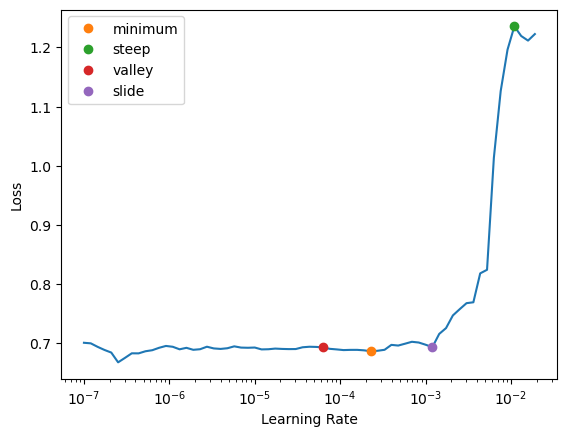

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.17793303728103638
valid_loss 0.20391534268856049
accuracy 0.925000011920929


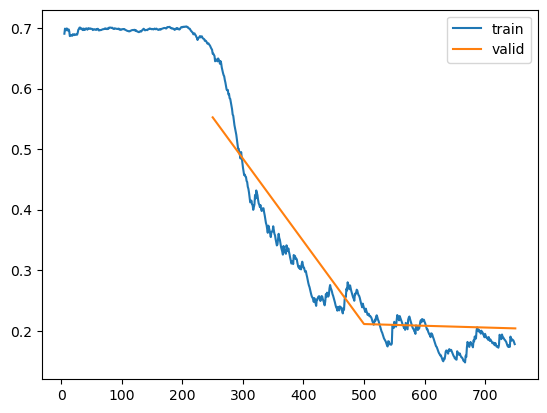

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_label_names], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
proc_civil_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): tensor([0, 0, 0, 0, 0, 0, 0])


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 270)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 270 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 270 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=0.03981071710586548, valley=0.00013182566908653826, slide=0.0004786300996784121)

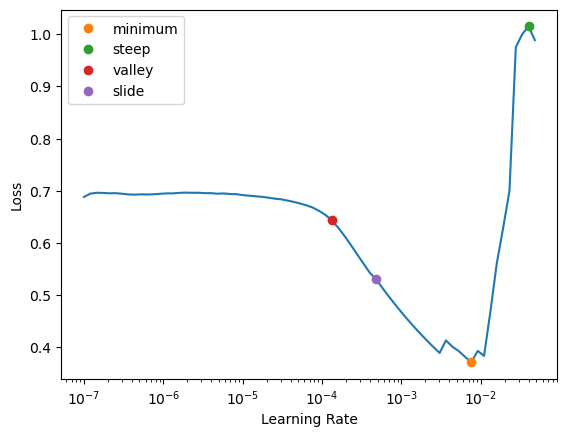

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.053676359355449677
valid_loss 0.08770094811916351
accuracy_multi 0.9778571128845215


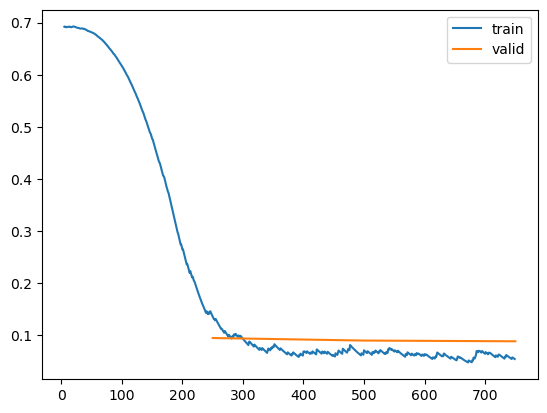

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_imdb_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_imdb_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9f661598a95b9a30.arrow


##### Step 3: `DataLoaders`

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"label_names": label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"label_names": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

,text,target
0,"Abysmal with a capital ""A"". This has got to be one of, if not THE, unfunniest show on TV right now. I'm about as anti-bush as it gets, but this show doesn't even get a chuckle out of me. What you think of Bush as a president has absolutely NOTHING to do with whether or not you'll like this piece of crap show. The ""jokes"" are not funny at all. For example, in a scene when lil bush has his underwear on his head: ""Welcome to camp al-qa-eeda!"". There is NOTHING funny about that. Is it even supposed to be joke? The commercials that were shown in the weeks leading up to the show, hyping it up, were funnier than the show itself, and that's just sad. Hopefully this does not even get considered for a second season. It shouldn't even have had a first.",neg
1,"I actually like the original, and this film has its ups and downs. Here's just a few:<br /><br />Ups: Most of the original voice cast returned.<br /><br />Downs: I didn't like the voice of Timon's Ma. I know she did a voice in The Simpsons, but that show is just plain stupid. <br /><br />Ups: We get to see Simba as a ""teenager.""<br /><br />Downs: They wasted it with a slug-slurping contest between Timon and Simba. <br /><br />Ups: It was Rafiki who told Timon about ""Hakuna Matata.""<br /><br />Downs: How did Pumbaa find out about it?<br /><br />Ups: Songs again. (some of the original songs were there, but they were just background music.)<br /><br />Downs: But stupid songs. (a.k.a. Timon's solo.)<br /><br />Overall, this is a pretty good movie. I'd recommend it for fans of the original. But",pos


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"especially considering I can count on one hand the romantic comedy films I have ever enjoyed.<br /><br />Minnie Driver is very good as the heart transplant patient, who has a mysterious connection to Duchovny's recently deceased wife. (I can think of",pos
1,"C'était complètement minable : à fuir absolument! <br /><br />This was an idiotic attempt to destroy classic source material, and thoroughly succeeded!<br /><br />Do not see this film under any circumstances unless you wish to have your ten euros tor",neg


In [ ]:
# YES: Will work now that we're using fastai `TfmDL`s` and transforms
learn.summary()

BaseModelWrapper (Input shape: 4 x 476)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 476 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 476 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=3.311311302240938e-05, steep=0.00363078061491251, valley=7.585775892948732e-05, slide=0.0003311311302240938)

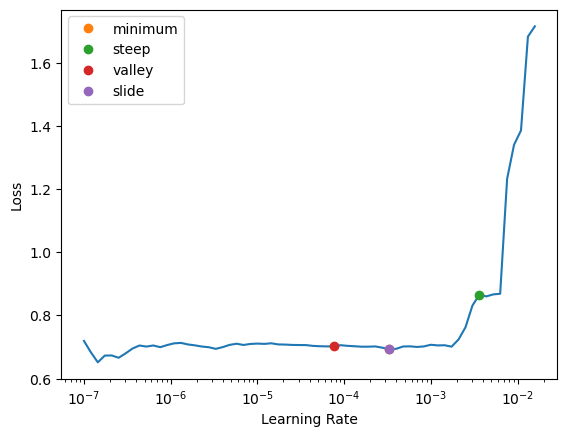

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.19156457483768463
valid_loss 0.20097337663173676
accuracy 0.9200000166893005


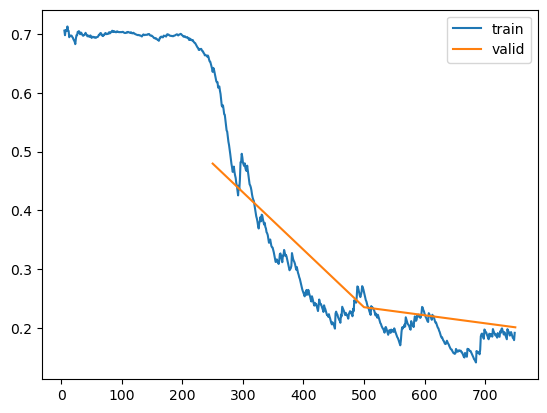

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"What a mess of a movie! If it wasnt for Eric Roberts and Susan Sarandon's performances,this movie would be a total waste! A very muddled plot and phony dialogue.Eric Roberts debut....where did his career go from this movie on?Nowhere but down!",neg,neg
1,"Ed Gein, one of the most famous serial killers of all time, he was the inspiration for famous movie killers like Norman Bates, Leatherface, and Buffalo Bill. He is also one of the most sick and disturbing killers of all time, I watched a documentary on him, so I know his story pretty well. When I saw this, I was curious because I thought it was supposed to be like a documentary re-enactment, but I have to say that this was just a pathetic waste of time. First off, the facts are completely wrong,",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_label_names], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_civil_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_civil_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-03ac06037501e9ff.arrow


##### Step 3: `DataLoaders`

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"label_names": civil_label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"label_names": civil_label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,No. Some people are calling Trump a wannabe dictator. He's certainly no socialist.,[]
1,"Trump did deals with crooks like Sater who is a convicted Federal felon with connections to the Russian mob which has deep ties to Putin. He tries to cover up these deals. Sater is one of several with contacts with corrupt oligarchs and tons of illegal money who opened offices in Trump tower offering money and deals to Trump when he was desparate for money after his bankruptcies. Sater worked for Trump and despite emails, photos and the foreclosed, litigation ridden Trump Soho deal, Trump says he does not know him. Cohen says he had nothing to do with Russia-- and look. Trump and his family are being investigated for trying to conceal Sater's involvement in Trump Soho which is a fraud on other investors and the banks involved. These types of deals with underworld figures tied to Putin open Trump to being enticed into participating in money laundering (he settled one case for $10 Million) and fraud and resulting blackmail-- a Russian mob technique-- do favor now, ask for one later.",[]
2,"Since I posted this comment, the phrase was changed to the correct ""queue jumper"".",[]
3,Nice story with a happy ending. Sniffing bombs is dangerous work.,[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Maybe the Pac 12 commissioner tacitly is agreement with on too much sporting event on the airwaves as his blundered launch of the Pac 12 ""Network"" still to this day manages to keep the conference off of about 70% of the LA market...the guy is stealin",[]
1,"Pete Davidson is a great comedian with a bright future. Amazing when you think that he has to deal with Crohns Disease in the prime of his youth... and even worse, his firefighter father's death in 9/11 ten years before the Crohns diagnosis.",[]


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 69)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 69 x 768        
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 69 x 3072       
Linear                          

##### Step 5: Train

SuggestedLRs(minimum=0.0006309573538601399, steep=0.02754228748381138, valley=9.120108734350652e-05, slide=0.004365158267319202)

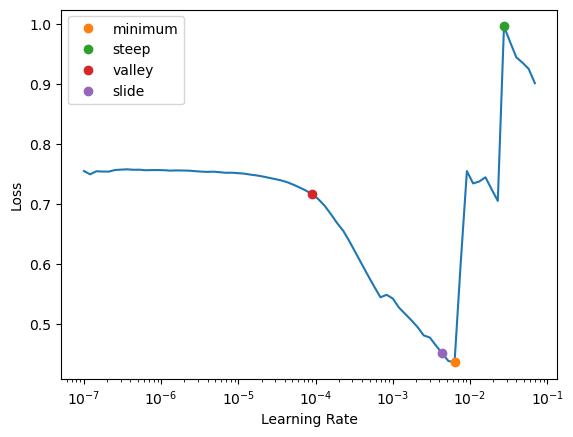

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.065407894551754
valid_loss 0.08553068339824677
accuracy_multi 0.9778571128845215


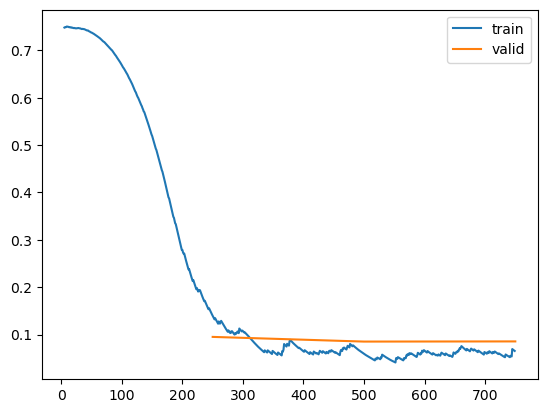

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Mr. Wohlforth, you should know that K12 is the Biggest part of the state's budget. Bigger than the Health & Social Services budget as you state. K12 is $1.28 Billion and DHSS is $1.08 Billion. Please get your facts straight. According to the NEA national, Alaska ranks 8th in teacher salaries out of the 50 States and DC. Way above average",[],[]
1,"The special education population is different today. It includes people you might otherwise work with and have over for coffee without ever knowing that there is a potential diagnoses. Even those with severe disabilities are in the classroom at least some of the time with aides. In a society that has shutdown most state and federally funded full-time adult care facilities, the effort at schools is to prepare even the severely disabled for a life immersed (at least partially) in society at large.",[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

## Mid-Level API: Examples

### Pretokenized

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(
    hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, batch_decode_kwargs={"label_names": label_names}
)

blocks = (txt_block, CategoryBlock)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the HF dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9f661598a95b9a30.arrow


In [ ]:
dls = dblock.dataloaders(proc_imdb_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Rais",neg
1,"Warning: Spoilers Galore!<br /><br />Tim Burton remaking this sui generis movie is about as sensible as remaking Psycho - oh, that's right, some idiot already did that - I rest my case.<br /><br />Movie opens with chimpnaut blundering a simulation, p",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"especially considering I can count on one hand the romantic comedy films I have ever enjoyed.<br /><br />Minnie Driver is very good as the heart transplant patient, who has a mysterious connection to Duchovny's recently deceased wife. (I can think of",pos
1,"C'était complètement minable : à fuir absolument! <br /><br />This was an idiotic attempt to destroy classic source material, and thoroughly succeeded!<br /><br />Do not see this film under any circumstances unless you wish to have your ten euros tor",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1635)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1635 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1635 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.9054607491852948e-07, steep=1.5848931980144698e-06, valley=9.999999747378752e-06, slide=0.0005754399462603033)

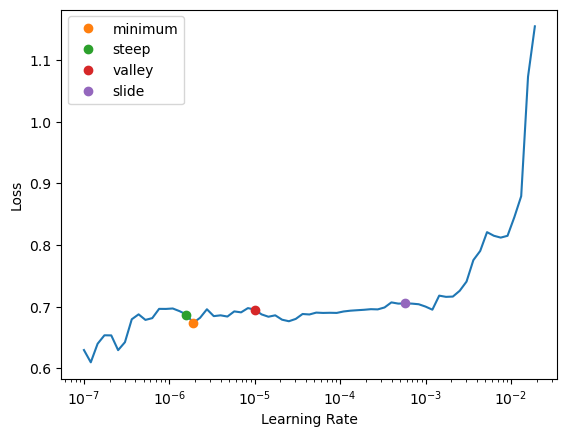

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1950085163116455
valid_loss 0.2226308435201645
accuracy 0.8999999761581421


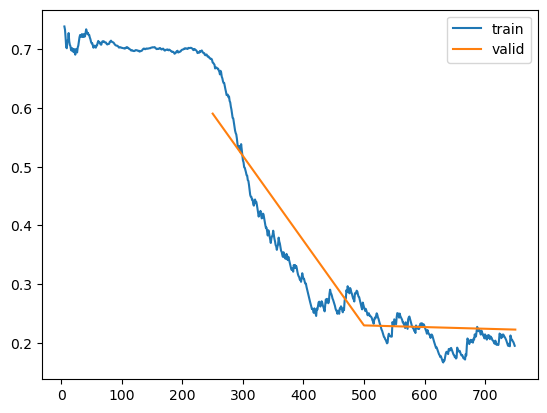

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"especially considering I can count on one hand the romantic comedy films I have ever enjoyed.<br /><br />Minnie Driver is very good as the heart transplant patient, who has a mysterious connection to Duchovny's recently deceased wife. (I can think of several awful films which have used this story line- I think there was an LMN movie with Jane Seymour) This film, however, is a keeper.<br /><br />Duchovny is sympathetic, and the scenes with his dog are cute and sad- the dog misses his deceased wif",pos,pos
1,"A clever overall story/location for a story. Action is respectable. The children are annoying and their motivation is unclear. The leading villain was a nice change but could have been better. ""I Love You"" was more overplayed than ""you complete me"" but at least Van Damme got a chance to show a little tenderness. One of Van Damme's better movies.",neg,neg


In [ ]:
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model)

blocks = (txt_block, MultiCategoryBlock(encoded=True, vocab=civil_label_names))
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_label_names], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-03ac06037501e9ff.arrow


In [ ]:
dls = dblock.dataloaders(proc_civil_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Oh, another ""we can't find the money"" program privatized prisons drum up to secure a massive profit. The government enforces the laws. How come the government doesn't cover jails and prison too? Lobbyists...That's why prisons and jails are privatised. Lobbyists... Three strikes you're out and mandatory minimums has been a boon for contractors. They've even bought cops, prosecutors and judges to railroad the poor and mainly black/colored folks. It's always the most vunerable than bears the brunt",[]
1,"As usual can't take Paul Jenkins seriously. He acts as if LEO's finally getting round to tabulating their kills for the first time last YEAR was something to be proud of. White cops have been murdering black folks since back when they weren't afraid to be photographed at lynchings. In fact the FBI admits the stats are woefully incomplete because a significant number of LEO's simply refuse to keep count of their kills. Could be why I've seen three different counts and breakdowns, including Jenkin",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Maybe the Pac 12 commissioner tacitly is agreement with on too much sporting event on the airwaves as his blundered launch of the Pac 12 ""Network"" still to this day manages to keep the conference off of about 70% of the LA market...the guy is stealin",[]
1,"Pete Davidson is a great comedian with a bright future. Amazing when you think that he has to deal with Crohns Disease in the prime of his youth... and even worse, his firefighter father's death in 9/11 ten years before the Crohns diagnosis.",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 270)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 270 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 270 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=0.12022644281387329, valley=0.00013182566908653826, slide=0.0030199517495930195)

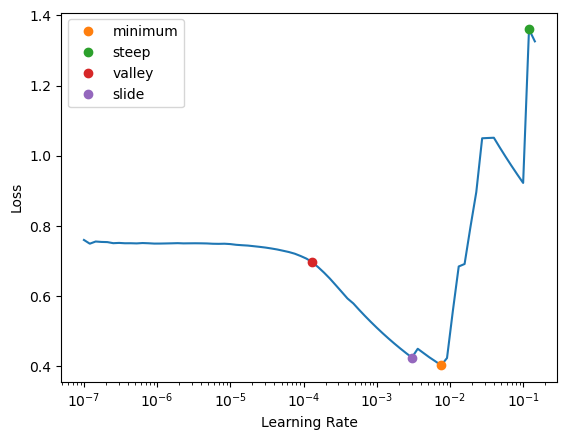

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.054043564945459366
valid_loss 0.08937415480613708
accuracy_multi 0.9778571128845215


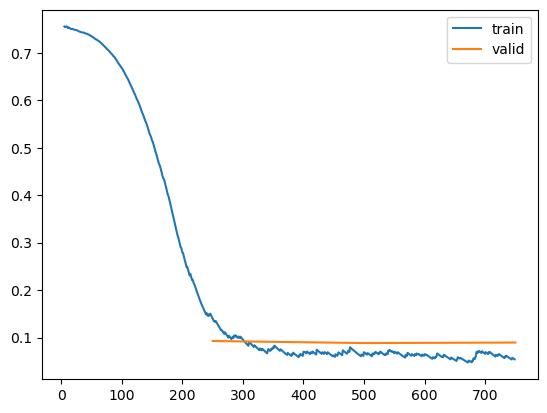

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Maybe the Pac 12 commissioner tacitly is agreement with on too much sporting event on the airwaves as his blundered launch of the Pac 12 ""Network"" still to this day manages to keep the conference off of about 70% of the LA market...the guy is stealing money with that salary he gets I'll tell you that...",[],[]
1,"If they truly believed that food supplies were in jeopardy and coastal cities were about to be flooded they would take immediate action. And when I say immediate action I don’t mean toying with windmills, solar panels and carbon taxes. I mean immediately switching over to the only technology available today that can meet our energy needs, nuclear power. Oh but nuclear power isn’t progressive. Exactly, until I see massive investment in nuclear power I know nobody really believes.",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (
    TextBlock(tokenize_tfm=tokenize_tfm, batch_decode_kwargs={"label_names": label_names}),
    CategoryBlock,
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Raising Victor Vargas became I was always aware that something didn't quite feel right. Victor Vargas suffers from a certain overconfidence on the director's part. Apparently, the director thought that the ethnic backdrop of a Latino family on the lower",neg
1,"(I'll indicate in this review the point where spoilers begin.) My dissatisfaction is split: 30% tone-deafness, 70% lackluster writing.<br /><br />The 30%: I agree with the first commenter's synopsis about the lack of diversity in the characters and scope of the stories. I was surprised how, this film, at best, woefully shortchanges the real NYC by presenting a collection of people and relationships so narrow as to come across as if it's inhabited only by the cast of Gossip Girl (this is coming f",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Think of it as an extreme form of detention without trial. Without commenting and taking a side on the US Foreign Policy, the process of Extraordinary Rendition involves taking persons suspected of terrorist activities to a foreign country, an opposi",pos
1,"What a disaster! Normally, when one critiques a historical movie, it's always fun to point out the inaccuracies that slip in, usually added by the writers to create more ""dramatic"" situations. However, ""Imperium: Nerone"" is a whole 'nuther kind of an",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1635)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1635 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1635 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.0063095735386013985, valley=6.30957365501672e-05, slide=0.0002754228771664202)

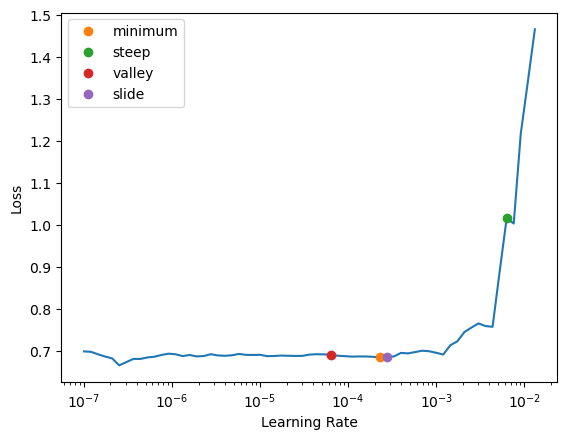

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.18056447803974152
valid_loss 0.19523751735687256
accuracy 0.9350000023841858


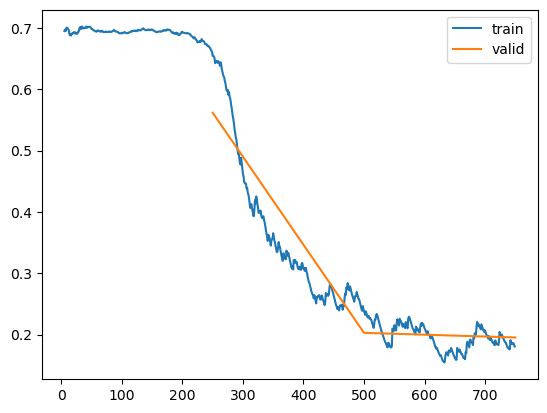

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Think of it as an extreme form of detention without trial. Without commenting and taking a side on the US Foreign Policy, the process of Extraordinary Rendition involves taking persons suspected of terrorist activities to a foreign country, an opposite to an extradition if you wish, to a place where torture is not a crime but a means to illicit information. Instead of staining your soil with blood of potentially innocent parties, you do so on foreign land where such tactics are accepted interrog",pos,pos
1,"What a disaster! Normally, when one critiques a historical movie, it's always fun to point out the inaccuracies that slip in, usually added by the writers to create more ""dramatic"" situations. However, ""Imperium: Nerone"" is a whole 'nuther kind of animal. In this movie you strain to find ANYTHING at all that is confirmed by the historical record amidst the farrago of nonsense and fiction presented as the life of Rome's bad-boy artist-emperor.<br /><br />And it's a pity, because Nero is one of th",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm), MultiCategoryBlock(encoded=True, vocab=civil_label_names))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(civil_label_names), splitter=ColSplitter())

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Oh, another ""we can't find the money"" program privatized prisons drum up to secure a massive profit. The government enforces the laws. How come the government doesn't cover jails and prison too? Lobbyists...That's why prisons and jails are privatised. Lobbyists... Three strikes you're out and mandatory minimums has been a boon for contractors. They've even bought cops, prosecutors and judges to railroad the poor and mainly black/colored folks. It's always the most vunerable than bears the brunt",[]
1,"As usual can't take Paul Jenkins seriously. He acts as if LEO's finally getting round to tabulating their kills for the first time last YEAR was something to be proud of. White cops have been murdering black folks since back when they weren't afraid to be photographed at lynchings. In fact the FBI admits the stats are woefully incomplete because a significant number of LEO's simply refuse to keep count of their kills. Could be why I've seen three different counts and breakdowns, including Jenkin",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"It was his campaign promise to fill Manila Bay with the bodies of drug dealers that got him elected. It is what the people wanted. He has taken down 6 of the top police and customs officials, drug tested the Philippine National Police (10% flunked an",[]
1,"You are either joking or just plain old immoral. Doyle was THE Canon lawyer at THE Vatican Embassy in Washington D.C. appointed under JP2. Yet after dealing with victims cases for years, he suddenly ""sees the light"" and starts working ""for"" us by wri",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 270)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 270 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 270 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=0.12022644281387329, valley=0.00013182566908653826, slide=0.0030199517495930195)

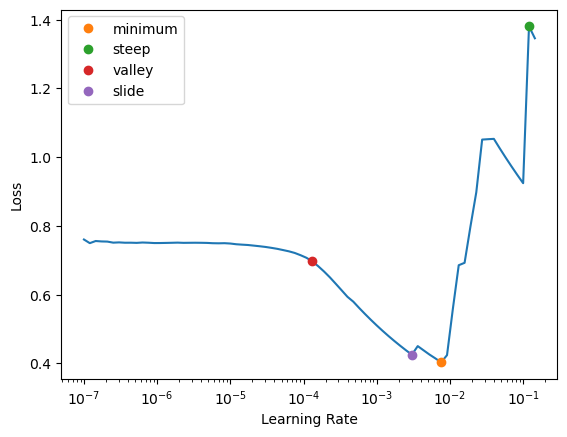

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.05404171347618103
valid_loss 0.08937311917543411
accuracy_multi 0.9778570532798767


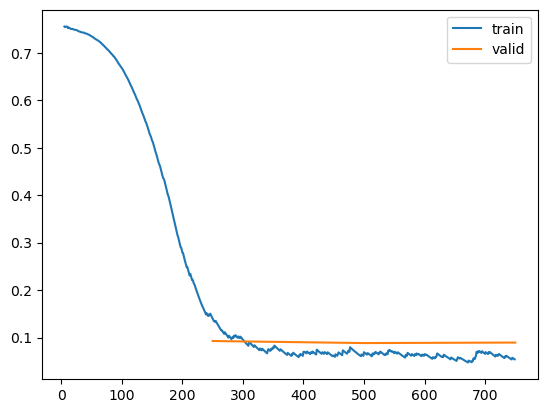

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"It was his campaign promise to fill Manila Bay with the bodies of drug dealers that got him elected. It is what the people wanted. He has taken down 6 of the top police and customs officials, drug tested the Philippine National Police (10% flunked and were fired) not just the poor people, he has indicted mayors and the head of the prisons. This was his promise and why the people elected him. They now think the people from other countries that don't like Dutarte don't like them. If you have not b",[],[]
1,"You are either joking or just plain old immoral. Doyle was THE Canon lawyer at THE Vatican Embassy in Washington D.C. appointed under JP2. Yet after dealing with victims cases for years, he suddenly ""sees the light"" and starts working ""for"" us by writing a paper to the American Bishops, a paper you need to read. A paper that is far far more about protecting the church and it's assets than about helping victims. In it he outlined the creation of ""committees"" to be secretly funded and controlled b",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Item-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(
        hf_arch=hf_arch,
        hf_config=hf_config,
        hf_tokenizer=hf_tokenizer,
        hf_model=hf_model,
        type_tfms=[tfm, tfm2],
        batch_decode_kwargs={"label_names": label_names},
    ),
    CategoryBlock,
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Raising Victor Vargas became I was always aware that something didn't quite feel right. Victor Vargas suffers from a certain overconfidence on the director's part. Apparently, the director thought that the ethnic backdrop of a Latino family on the lower",neg
1,"(I'll indicate in this review the point where spoilers begin.) My dissatisfaction is split: 30% tone-deafness, 70% lackluster writing.<br /><br />The 30%: I agree with the first commenter's synopsis about the lack of diversity in the characters and scope of the stories. I was surprised how, this film, at best, woefully shortchanges the real NYC by presenting a collection of people and relationships so narrow as to come across as if it's inhabited only by the cast of Gossip Girl (this is coming f",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"especially considering I can count on one hand the romantic comedy films I have ever enjoyed.<br /><br />Minnie Driver is very good as the heart transplant patient, who has a mysterious connection to Duchovny's recently deceased wife. (I can think of",pos
1,"C'était complètement minable : à fuir absolument! <br /><br />This was an idiotic attempt to destroy classic source material, and thoroughly succeeded!<br /><br />Do not see this film under any circumstances unless you wish to have your ten euros tor",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1635)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1635 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1635 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=1.0964781722577754e-06, valley=6.30957365501672e-05, slide=0.0002754228771664202)

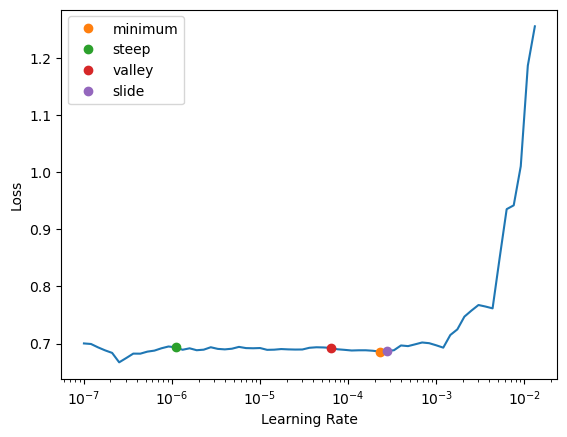

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.18056099116802216
valid_loss 0.19524940848350525
accuracy 0.9350000023841858


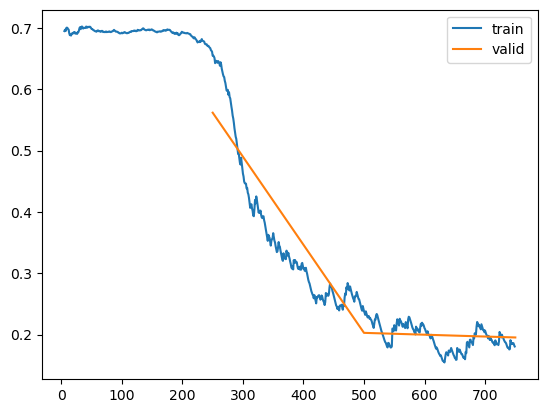

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"especially considering I can count on one hand the romantic comedy films I have ever enjoyed.<br /><br />Minnie Driver is very good as the heart transplant patient, who has a mysterious connection to Duchovny's recently deceased wife. (I can think of several awful films which have used this story line- I think there was an LMN movie with Jane Seymour) This film, however, is a keeper.<br /><br />Duchovny is sympathetic, and the scenes with his dog are cute and sad- the dog misses his deceased wif",pos,pos
1,"A clever overall story/location for a story. Action is respectable. The children are annoying and their motivation is unclear. The leading villain was a nice change but could have been better. ""I Love You"" was more overplayed than ""you complete me"" but at least Van Damme got a chance to show a little tenderness. One of Van Damme's better movies.",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, type_tfms=[tfm, tfm2]),
    MultiCategoryBlock(encoded=True, vocab=civil_label_names),
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader(civil_label_names),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Oh, another ""we can't find the money"" program privatized prisons drum up to secure a massive profit. The government enforces the laws. How come the government doesn't cover jails and prison too? Lobbyists...That's why prisons and jails are privatised. Lobbyists... Three strikes you're out and mandatory minimums has been a boon for contractors. They've even bought cops, prosecutors and judges to railroad the poor and mainly black/colored folks. It's always the most vunerable than bears the brunt",[]
1,"As usual can't take Paul Jenkins seriously. He acts as if LEO's finally getting round to tabulating their kills for the first time last YEAR was something to be proud of. White cops have been murdering black folks since back when they weren't afraid to be photographed at lynchings. In fact the FBI admits the stats are woefully incomplete because a significant number of LEO's simply refuse to keep count of their kills. Could be why I've seen three different counts and breakdowns, including Jenkin",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Maybe the Pac 12 commissioner tacitly is agreement with on too much sporting event on the airwaves as his blundered launch of the Pac 12 ""Network"" still to this day manages to keep the conference off of about 70% of the LA market...the guy is stealin",[]
1,"Pete Davidson is a great comedian with a bright future. Amazing when you think that he has to deal with Crohns Disease in the prime of his youth... and even worse, his firefighter father's death in 9/11 ten years before the Crohns diagnosis.",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 270)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 270 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 270 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=0.12022644281387329, valley=0.00013182566908653826, slide=0.0030199517495930195)

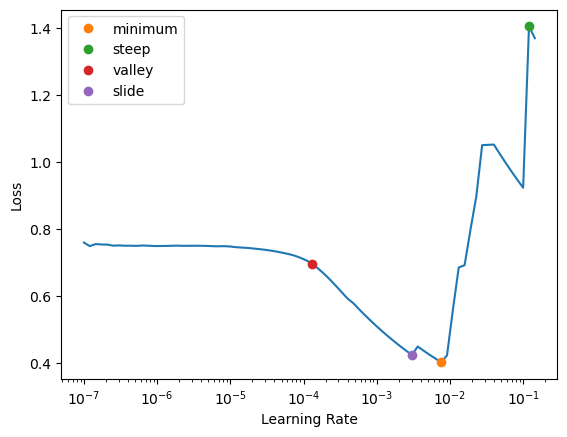

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.054044175893068314
valid_loss 0.08937305212020874
accuracy_multi 0.9778571128845215


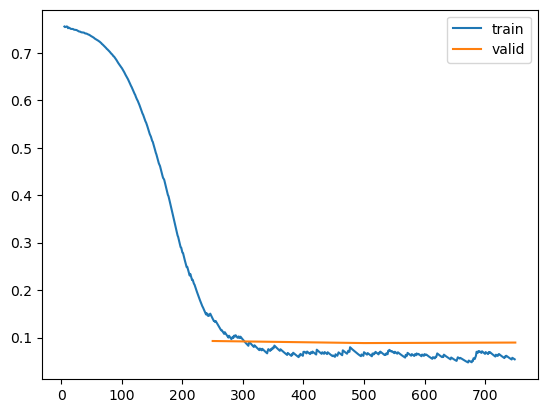

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Maybe the Pac 12 commissioner tacitly is agreement with on too much sporting event on the airwaves as his blundered launch of the Pac 12 ""Network"" still to this day manages to keep the conference off of about 70% of the LA market...the guy is stealing money with that salary he gets I'll tell you that...",[],[]
1,"If they truly believed that food supplies were in jeopardy and coastal cities were about to be flooded they would take immediate action. And when I say immediate action I don’t mean toying with windmills, solar panels and carbon taxes. I mean immediately switching over to the only technology available today that can meet our energy needs, nuclear power. Oh but nuclear power isn’t progressive. Exactly, until I see massive investment in nuclear power I know nobody really believes.",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(self.dls.before_batch, tfm_class=BatchTokenizeTransform)
    item_tok_tfm = getattr(self.dls.dataset, "item_tokenize_transform", None)

    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    # we need to tokenize our items *if* we are not using the mid-level API batch-time tokenization
    if batch_tok_tfm is None and item_tok_tfm is None:
        inputs_d = dict(
            hf_tokenizer(
                items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt"
            )
        )
        items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if isinstance(item_dec_labels, str) or isinstance(item_dec_labels, int):
                item_dec_labels = [trg_labels[int(item_dec_labels)]]
            elif len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L219){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

### Multiclass

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.7548438310623169,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.2451561689376831, 0.7548438310623169]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.7709066271781921,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.22909341752529144, 0.7709066271781921]},
 {'label': 0,
  'score': 0.5116910338401794,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.5116910338401794, 0.4883088767528534]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level.pkl")

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': 'neg',
  'score': 0.8155748844146729,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.8155748844146729, 0.18442511558532715]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 'pos',
  'score': 0.7908961176872253,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.20910383760929108, 0.7908961176872253]},
 {'label': 'neg',
  'score': 0.5522531270980835,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.5522531270980835, 0.4477468430995941]}]

### Multilabel

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.056231789290905,
   0.0009894628310576081,
   0.0013257918180897832,
   0.001927447272464633,
   0.03683622553944588,
   0.0021066502667963505,
   0.0013976709451526403]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
inf_learn.loss_func.thresh = 0.02


comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes.
No enchiladas for them!
"""
inf_learn.blurr_predict(comment)

[{'labels': ['toxicity', 'insult'],
  'scores': [0.04104480519890785, 0.02719004638493061],
  'class_indices': [1, 0, 0, 0, 1, 0, 0],
  'class_labels': ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
  'probs': [0.04104480519890785,
   0.0008754548034630716,
   0.0012173685245215893,
   0.00152481475379318,
   0.02719004638493061,
   0.0016568010905757546,
   0.0013901044148951769]}]

In [ ]:
# |echo:false
try:
    del inf_learn
except:
    pass
finally:
    clean_memory()

## Text Generation

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L292){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

## Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()